In [1]:
from concurrent.futures import ThreadPoolExecutor, as_completed

import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler

from keras.models import Model
from keras.optimizers import Adam
from keras.models import load_model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Input, Conv1D, BatchNormalization, LeakyReLU, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout, Activation, Add, Flatten

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.callbacks import ModelCheckpoint

2024-07-30 12:28:14.206395: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-30 12:28:14.257856: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 12:28:14.257891: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 12:28:14.257922: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-30 12:28:14.267015: I tensorflow/core/platform/cpu_feature_g

# Load csv from Desktop

In [2]:
NUM_CLASSES = 2
CLASSES = np.array(['Legitimate', 'Suspicious'])
DATASET_DIR = "./"
VECTOR_LENGTH = 1 * 275

def csvToVector(file_path):
    data = pd.read_csv(file_path, header=None)
    vector = data.values.flatten()
    return vector

def process_file(class_idx, file_path):
    vector = csvToVector(file_path)
    return (vector, class_idx)

def load_data(dataset_dir):
    X = []
    y = []
    subdirs = ['benign_cms3', 'malware_cms3']
    futures = []

    with ThreadPoolExecutor() as executor:
        for class_idx, class_name in enumerate(subdirs):
            class_dir = os.path.join(dataset_dir, class_name)
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.csv'):
                    file_path = os.path.join(class_dir, file_name)
                    futures.append(executor.submit(process_file, class_idx, file_path))

        for future in as_completed(futures):
            vector, class_idx = future.result()
            X.append(vector)
            y.append(class_idx)

    X = np.array(X)
    y = np.array(y)
    return X, y

In [3]:
X, y = load_data(DATASET_DIR)

In [4]:
print(X.shape)
print(y.shape)
print(X)
print(y)

(4020, 275)
(4020,)
[[   71 10421   213 ... 10472   817 10531]
 [  138 11751   168 ... 14812   645 20643]
 [   81  9470   233 ... 10296   486  9684]
 ...
 [  147 10718   218 ...  3091   838  2358]
 [   93  9696   127 ... 15548  6766 14263]
 [  146 30880   218 ... 23489 10092  2814]]
[0 0 0 ... 1 1 1]


# Train, Validation, Test Split and Nomalize

In [5]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train = X_train / 299.0
X_val = X_val / 299.0
X_test = X_test / 299.0

y_train = to_categorical(y_train, 2)
y_val = to_categorical(y_val, 2)
y_test = to_categorical(y_test, 2)

In [6]:
print(X_train.shape)
print(X_test.shape)
#print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
#print(y_val.shape)

(2251, 275)
(1206, 275)
(2251, 2)
(1206, 2)


# 1D CNN Architecture

In [7]:
input_layer = Input(shape=(VECTOR_LENGTH, 1))

x = Conv1D(filters=32, kernel_size=3, padding='same')(input_layer)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=64, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=128, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Flatten()(x)

x = Dense(256)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate=0.5)(x)

x = Dense(NUM_CLASSES)(x)
output_layer = Activation('softmax')(x)

model = Model(input_layer, output_layer)

opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

2024-07-30 12:28:32.120486: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31350 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:06:00.0, compute capability: 7.0
2024-07-30 12:28:32.121036: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31350 MB memory:  -> device: 1, name: CUDA GPU, pci bus id: 0000:2f:00.0, compute capability: 7.0
2024-07-30 12:28:32.121530: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 31350 MB memory:  -> device: 2, name: CUDA GPU, pci bus id: 0000:86:00.0, compute capability: 7.0


In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 275, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 275, 32)           128       
                                                                 
 batch_normalization (Batch  (None, 275, 32)           128       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 275, 32)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 137, 32)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 137, 64)           6208  

# CheckPoint

In [9]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
checkpoint = ModelCheckpoint(
    filepath='/tmp/CMS3_CNN_1D_CheckPoint.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

# Model Training

In [10]:
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[reduce_lr, checkpoint])

Epoch 1/100


2024-07-30 12:28:34.814076: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-07-30 12:28:36.229334: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f953d417cc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-30 12:28:36.229371: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): CUDA GPU, Compute Capability 7.0
2024-07-30 12:28:36.229377: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): CUDA GPU, Compute Capability 7.0
2024-07-30 12:28:36.229382: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): CUDA GPU, Compute Capability 7.0
2024-07-30 12:28:36.235198: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-30 12:28:36.327717: I ./tensorflow/compiler/jit/device_compiler.h:186] Compi

71/71 [==============================] - ETA: 0s - loss: 0.4017 - accuracy: 0.8450
Epoch 1: val_accuracy improved from -inf to 0.87389, saving model to /tmp/CMS3_CNN_1D_CheckPoint.h5
71/71 [==============================] - 6s 14ms/step - loss: 0.4017 - accuracy: 0.8450 - val_loss: 0.2842 - val_accuracy: 0.8739 - lr: 0.0010
Epoch 2/100
10/71 [===>..........................] - ETA: 0s - loss: 0.2291 - accuracy: 0.8969

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


71/71 [==============================] - ETA: 0s - loss: 0.2415 - accuracy: 0.9165
Epoch 2: val_accuracy improved from 0.87389 to 0.91652, saving model to /tmp/CMS3_CNN_1D_CheckPoint.h5
71/71 [==============================] - 1s 8ms/step - loss: 0.2415 - accuracy: 0.9165 - val_loss: 0.2501 - val_accuracy: 0.9165 - lr: 0.0010
Epoch 3/100
64/71 [==========================>...] - ETA: 0s - loss: 0.1972 - accuracy: 0.9297
Epoch 3: val_accuracy improved from 0.91652 to 0.94316, saving model to /tmp/CMS3_CNN_1D_CheckPoint.h5
71/71 [==============================] - 1s 8ms/step - loss: 0.1979 - accuracy: 0.9285 - val_loss: 0.2645 - val_accuracy: 0.9432 - lr: 0.0010
Epoch 4/100
64/71 [==========================>...] - ETA: 0s - loss: 0.1712 - accuracy: 0.9375
Epoch 4: val_accuracy did not improve from 0.94316
71/71 [==============================] - 0s 7ms/step - loss: 0.1690 - accuracy: 0.9382 - val_loss: 0.1877 - val_accuracy: 0.9236 - lr: 0.0010
Epoch 5/100
63/71 [=========================

# Load Best CheckPoint

In [11]:
cp_model = load_model('/tmp/CMS3_CNN_1D_CheckPoint.h5')
cp_model.evaluate(X_test, y_test, batch_size=1000)

2/2 [==============================] - 0s 20ms/step - loss: 0.0884 - accuracy: 0.9693


[0.0883903056383133, 0.9693200588226318]

# Evaluate

In [12]:
y_pred = cp_model.predict(X_test)

38/38 [==============================] - 0s 2ms/step


In [13]:
preds_single = CLASSES[np.argmax(y_pred, axis = -1)]
actual_single = CLASSES[np.argmax(y_test, axis = -1)]

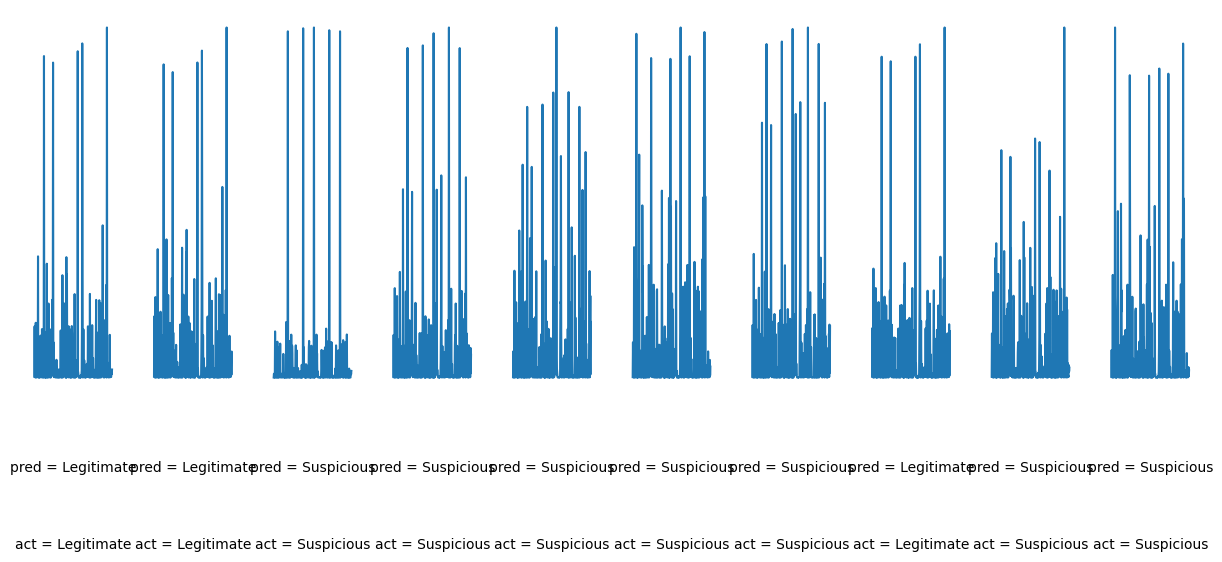

In [14]:
n_to_show = 10
indices = np.random.choice(range(len(X_test)), n_to_show)

fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    data = X_test[idx]
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.plot(data)
    ax.axis('off')
    ax.text(0.5, -0.2, 'pred = ' + str(preds_single[idx]), fontsize=10, ha='center', transform=ax.transAxes) 
    ax.text(0.5, -0.4, 'act = ' + str(actual_single[idx]), fontsize=10, ha='center', transform=ax.transAxes)

plt.show()

# Classification Results

In [15]:
y_pred_classes = tf.argmax(y_pred, axis=1)
y_test_classes = tf.argmax(y_test, axis=1)

print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       623
           1       0.98      0.96      0.97       583

    accuracy                           0.97      1206
   macro avg       0.97      0.97      0.97      1206
weighted avg       0.97      0.97      0.97      1206



# Confusion MatriX

In [16]:
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

class_labels = ['Legitimate', 'Suspicious']

conf_matrix_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)

print("Confusion Matrix:")
print(conf_matrix_df)

Confusion Matrix:
            Legitimate  Suspicious
Legitimate         610          13
Suspicious          24         559
